# Segmenting and Clustering Neighborhoods in Toronto

By Thibault D.

## Table of Contents
 
1. Wikipedia Scrapping
2. Geolocalization
3. Exploration and Clustering

In [121]:
# import libraries
# url fetch
import requests
from pandas.io.json import json_normalize

# scrapping
# !conda install beautifulsoup4
from bs4 import BeautifulSoup

# data
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np

# geolocalization
from geopy.geocoders import Nominatim
import geocoder

# plot
import folium
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# KMean clustering
from sklearn.cluster import KMeans

# PART 1: START  
__________________

## 1. Wikipedia Scrapping

In this section, we use the BeautifulSoup library to extract the table containing the list of Neighborhood in Toronto.
The following steps are followed:
1. Create a soup object that contains the webpage data.
2. Retrieve the subset of HTML code which contains the table data.
3. Extract the headers from the table.
4. Extract the content of the table.

**Step 1: Create a soup object that contains the webpage data.**

In [5]:
# url to be scrapped
URL = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [6]:
# GET request
request = requests.get(URL)
data = request.text

# convert request to soup
soup = BeautifulSoup(data, "lxml")

In [7]:
# display content of soupd
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of postal codes of Canada: M - Wikipedia
  </title>
  <script>
   document.documentElement.className = document.documentElement.className.replace( /(^|\s)client-nojs(\s|$)/, "$1client-js$2" );
  </script>
  <script>
   (window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":false,"wgNamespaceNumber":0,"wgPageName":"List_of_postal_codes_of_Canada:_M","wgTitle":"List of postal codes of Canada: M","wgCurRevisionId":876823784,"wgRevisionId":876823784,"wgArticleId":539066,"wgIsArticle":true,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Communications in Ontario","Postal codes in Canada","Toronto","Ontario-related lists"],"wgBreakFrames":false,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wg

As we can see above, the data is contained in a **table**, the headers are stored between **th** tags while the data is stored using **td** tags.

**Step 2: Retrieve the subset of HTML code which contains the table data.**

In [8]:
# extract the table
match = soup.find('table',class_='wikitable sortable')
print(match)

<table class="wikitable sortable">
<tbody><tr>
<th>Postcode</th>
<th>Borough</th>
<th>Neighbourhood
</th></tr>
<tr>
<td>M1A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M2A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
</td></tr>
<tr>
<td>M4A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Victoria_Village" title="Victoria Village">Victoria Village</a>
</td></tr>
<tr>
<td>M5A</td>
<td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
<td><a href="/wiki/Harbourfront_(Toronto)" title="Harbourfront (Toronto)">Harbourfront</a>
</td></tr>
<tr>
<td>M5A</td>
<td><a href="/wiki/Downtown_Toronto" title="Downtown Toronto">Downtown Toronto</a></td>
<td><a href="/wiki/Regent_Park" title="Regent Park">Regent Park</a>
</td></tr>
<tr>
<td>M6A</td>

**Step 3: Extract the headers from the table.**

In [9]:
# fetch columns names
headers = soup.find('table',class_='wikitable sortable').find('tbody').find_all('th')
columns = [head.text.strip() for head in headers]
columns

['Postcode', 'Borough', 'Neighbourhood']

In [10]:
# create new dataframe used to store the table data
zip_canada = pd.DataFrame(columns=['PostalCode', 'Borough', 'Neighborhood'])

**Step 4: Extract the content of the table.**

In [11]:
# fetch table rows tr
data_rows = soup.find('table',class_='wikitable sortable').find('tbody').find_all('tr')

# fetch table cells td
for data_row in data_rows:
    data_split = data_row.find_all('td')

    if len(data_split)>0:
        postcode = data_split[0].text.strip()
        borough = data_split[1].text.strip()
        neighborhood = data_split[2].text.strip()
        
        zip_canada = zip_canada.append({'PostalCode':postcode,
                                        'Borough':borough,
                                        'Neighborhood':neighborhood},ignore_index=True)

zip_canada.head(11)

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


## Data cleanup

In this section, the data is processed and invalid data is eliminated. The following steps are applied:
1. Delete row where the Borough is defined as **"Not assigned"**
2. Concatenate neighborhoods with the same PostalCode
3. Replace unassigned Neighborhood by the Borough name
4. We display the shape of the cleaned DataFrame

**Step 1: Delete row where the Borough is defined as "Not assigned"**

In [12]:
# Step 1
clean_df1 = zip_canada[zip_canada['Borough']!='Not assigned'].reset_index(drop=True)
clean_df1.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Not assigned
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


**Step 2: Concatenate neighborhoods with the same PostalCode**

In [13]:
# group by PostalCode and Borough, then concatenate the Neighborhoods.
clean_df2 = clean_df1.groupby(['PostalCode','Borough'])['Neighborhood'].apply(lambda x: ', '.join(x)).reset_index()

We verify that there are no longer any duplicates in the 'PostalCode' columns.

In [14]:
print('Checking for duplicates...')
print('Are there PostalCode duplicates?',~clean_df2['PostalCode'].value_counts().max()==1)

Checking for duplicates...
Are there PostalCode duplicates? False


In [15]:
clean_df2.tail(10)

,PostalCode,Borough,Neighborhood
93,M9A,Etobicoke,Islington Avenue
94,M9B,Etobicoke,"Cloverdale, Islington, Martin Grove, Princess ..."
95,M9C,Etobicoke,"Bloordale Gardens, Eringate, Markland Wood, Ol..."
96,M9L,North York,Humber Summit
97,M9M,North York,"Emery, Humberlea"
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, Martin Grove Gardens, Richv..."
101,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ..."
102,M9W,Etobicoke,Northwest


**Step 3: Replace unassigned Neighborhood by the Borough name**

We first list rows where the Neighborhood contains "Not assigned".

In [16]:
clean_df2[clean_df2['Neighborhood'].str.contains('Not assigned')]

,PostalCode,Borough,Neighborhood
85,M7A,Queen's Park,Not assigned


Only one record contains an unassigned Neighborhood name. We replace it.

In [17]:
clean_df2.loc[clean_df2['Neighborhood'].str.contains('Not assigned'),'Neighborhood'] = clean_df2.loc[clean_df2['Neighborhood'].str.contains('Not assigned'),'Borough']

We verify that the data is now cleaned:

In [18]:
print('Checking for unassigned Neighborhood...')
print('Are there unassigned neighborhood?',~clean_df2[clean_df2['Neighborhood'].str.contains('Not assigned')]['Neighborhood'].count()==1)

Checking for unassigned Neighborhood...
Are there unassigned neighborhood? False


**Step 4: Verification**

In [19]:
print("There are {} records in the DataFrame".format(clean_df2.shape[0]))

There are 103 records in the DataFrame


In [20]:
print("The shape of the DataFrame is:")
print(clean_df2.shape)

The shape of the DataFrame is:
(103, 3)


# PART 1: END  
__________________  
# PART 2: START  

## 2.Geolocalization

In this section, we retrieve the latitude and the longitude coordinates of each neighborhood. We loop through every row in our DataFrame and retrieve the latitude and longitude.

In [21]:
zip_canada = pd.DataFrame(columns = list(clean_df2.columns)+['Latitude','Longitude'])
zip_canada

,PostalCode,Borough,Neighborhood,Latitude,Longitude


In order to geolocalize the neighborhood, we use the ARCGIS Service intead of the *geocoder.google*. ARCGIS is more reliable and gives accurate results after a single call to the API.

Geocoder Documentation:  
https://media.readthedocs.org/pdf/geocoder/latest/geocoder.pdf

In [22]:
# set counter of API calls
api_calls = 0

for postalcode, borough, neighborhood in zip(clean_df2['PostalCode'],clean_df2['Borough'],clean_df2['Neighborhood']):  
    # initialize your variable to None
    lat_lng_coords = None

    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario,Canada'.format(postalcode))
        lat_lng_coords = g.latlng
        api_calls+=1

    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    
    zip_canada = zip_canada.append({
        'PostalCode':postalcode,
        'Borough':borough,
        'Neighborhood':neighborhood,
        'Latitude':latitude,
        'Longitude':longitude
    },ignore_index=True)
    
print('All locations have been retrieved.')
print('{} calls to the API were made.'.format(api_calls))

All locations have been retrieved.
103 calls to the API were made.


In [23]:
zip_canada.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.811650,-79.195561
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785605,-79.158701
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765690,-79.175299
3,M1G,Scarborough,Woburn,43.768216,-79.217610
4,M1H,Scarborough,Cedarbrae,43.769608,-79.239440
5,M1J,Scarborough,Scarborough Village,43.743085,-79.232172
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.726260,-79.263670
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.713213,-79.284910
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.723575,-79.234976
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.696690,-79.260069


In [24]:
# save csv file
zip_canada.to_csv("./zip_canada.csv")

# PART 2: END  
__________________  
# PART 3: START  

##  3. Exploration and Clustering

In this section, we will explore the data and use Foursquare API to query information about the venues in each neighborhood.  
Use the geocoder library to get the location of Toronto.

### 3.a. Exploration 

In [25]:
address = 'Toronto, Ontario, Canada'
geolocator = Nominatim(user_agent='ny_explorer')
location = geolocator.geocode(address)
latitde = location.latitude
longitude = location.longitude

print('The geographical coordinate of Toronto are {},{}.'.format(latitude,longitude))

The geographical coordinate of Toronto are 43.71174000000008,-79.387207.


**Create a map of Toronto with Neighborhoods**

In [26]:
# create map of Toronto
map_toronto = folium.Map(location=[latitude,longitude],zoom_start=12)

# add markers
for lat, lng, borough, neighborhood, postal in zip(zip_canada['Latitude'],zip_canada['Longitude'],
                                                  zip_canada['Borough'],zip_canada['Neighborhood'],
                                                  zip_canada['PostalCode']):
    label = '{}, {}, {}'.format(neighborhood,borough,postal)
    label = folium.Popup(label,parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)

map_toronto

**Filter Borough**  
In this section, we will be working with **ALL** Neighborhoods.

In [27]:
toronto_df = zip_canada.reset_index(drop=True) 
toronto_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.811650,-79.195561
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785605,-79.158701
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765690,-79.175299
3,M1G,Scarborough,Woburn,43.768216,-79.217610
4,M1H,Scarborough,Cedarbrae,43.769608,-79.239440
5,M1J,Scarborough,Scarborough Village,43.743085,-79.232172
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.726260,-79.263670
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.713213,-79.284910
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.723575,-79.234976
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.696690,-79.260069


Now that we have identified a subset of neighborhoods to work with, we will use the Foursquare API to retrieve information about venues in these neighborhoods.

In [159]:
# Connection to Foursquare API
CLIENT_ID = "BCHEH0XGR45MQ0DEPAW2Y1PAU3ETQUQC4Y2FXYXUKLZGAOBX"
CLIENT_SECRET = "KZJHNBUOPOXCG0CP3HBUDWJPV2DPBMTJHD33FKEVZ1YGL5UQ"
VERSION = '20180605'

#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [29]:
toronto_df.loc[0, 'Neighborhood']

'Rouge, Malvern'

Get the neighborhood's latitude and longitude values.

In [30]:
neighborhood_latitude = toronto_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Rouge, Malvern are 43.81165000000004, -79.19556138899998.


#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.

In [31]:
# obtain top 100 venues in The Beaches wthin a radius of 500 meters
radius = 500
LIMIT = 100

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?&client_id=BCHEH0XGR45MQ0DEPAW2Y1PAU3ETQUQC4Y2FXYXUKLZGAOBX&client_secret=KZJHNBUOPOXCG0CP3HBUDWJPV2DPBMTJHD33FKEVZ1YGL5UQ&v=20180605&ll=43.81165000000004,-79.19556138899998&radius=500&limit=100'

In [32]:
results = requests.get(url).json()

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [33]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [34]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Canadian Appliance Source Whitby,Home Service,43.808353,-79.191331


In [35]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

1 venues were returned by Foursquare.


#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [36]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    """
    Function:
        Use Foursquare API to retrive the top 100 venues associated to a neighborhood.
    Inputs:
        names: pandas Series containing the names of the neighborhoods.
        latitudes: pandas Series containting the latitudes of each neighborhood.
        longitudes: pandas Series containing the longitudes of each neighborhood.
        radius: maximum distance in meters between the center of the neighborhood and the venue.
    Outputs:
        pandas DataFrame containing the set of retrieved venues.
    """
    # initiate an empty list of venues
    venues_list=[]
    index = 1
    
    # loop through the data
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
        print('{}. {} DONE...{} venues found.'.format(index,name,len(results)))
        index+=1

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Let's now use this function to retrieve the venues from the boroughs of Toronto. 

In [37]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

1. Rouge, Malvern DONE...1 venues found.
2. Highland Creek, Rouge Hill, Port Union DONE...2 venues found.
3. Guildwood, Morningside, West Hill DONE...4 venues found.
4. Woburn DONE...5 venues found.
5. Cedarbrae DONE...2 venues found.
6. Scarborough Village DONE...4 venues found.
7. East Birchmount Park, Ionview, Kennedy Park DONE...6 venues found.
8. Clairlea, Golden Mile, Oakridge DONE...10 venues found.
9. Cliffcrest, Cliffside, Scarborough Village West DONE...11 venues found.
10. Birch Cliff, Cliffside West DONE...6 venues found.
11. Dorset Park, Scarborough Town Centre, Wexford Heights DONE...3 venues found.
12. Maryvale, Wexford DONE...2 venues found.
13. Agincourt DONE...16 venues found.
14. Clarks Corners, Sullivan, Tam O'Shanter DONE...11 venues found.
15. Agincourt North, L'Amoreaux East, Milliken, Steeles East DONE...2 venues found.
16. L'Amoreaux West, Steeles West DONE...12 venues found.
17. Upper Rouge DONE...0 venues found.
18. Hillcrest Village DONE...2 venues found.
19

#### Let's check the size of the resulting dataframe

In [38]:
print(toronto_venues.shape)
toronto_venues.head()

(2409, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.811650,-79.195561,Canadian Appliance Source Whitby,43.808353,-79.191331,Home Service
1,"Highland Creek, Rouge Hill, Port Union",43.785605,-79.158701,Affordable Toronto Movers,43.787919,-79.162977,Moving Target
2,"Highland Creek, Rouge Hill, Port Union",43.785605,-79.158701,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood, Morningside, West Hill",43.765690,-79.175299,The Strawberry Patch,43.764738,-79.173081,Tea Room
4,"Guildwood, Morningside, West Hill",43.765690,-79.175299,Homestead Roofing Repair,43.765140,-79.178663,Construction & Landscaping


Let's check how many venues were returned for each neighborhood

In [39]:
toronto_venues.groupby('Neighborhood').count()[['Venue Category']].sort_values('Venue Category',ascending=False)

,Venue Category
Neighborhood,
"Adelaide, King, Richmond",100
Business Reply Mail Processing Centre 969 Eastern,100
"Ryerson, Garden District",100
"First Canadian Place, Underground city",100
Stn A PO Boxes 25 The Esplanade,100
"Design Exchange, Toronto Dominion Centre",100
"Commerce Court, Victoria Hotel",100
Canada Post Gateway Processing Centre,100
St. James Town,100


#### Let's find out how many unique categories can be curated from all the returned venues

In [40]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 256 uniques categories.


#### Analyze Each Neighborhood

In [41]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

And let's examine the new dataframe size.

In [42]:
toronto_onehot.shape

(2409, 256)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [43]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head(10)

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Candy Store,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fish & Chips Shop,Fish Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Halal Restaurant,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Housing Development,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.0,0.0,0.0,0.04,0.0,0.0,0.010000,0.0,0.0,0.03,0.0,0.0,0.0,0.000000,0.0,0.000000,0.03000,0.0,0.03,0.0,0.000000,0.01000,0.000000,0.000000,0.0,0.000000,0.02,0.0,0.01,0.020000,0.0,0.0,0.0000,0.01,0.02,0.01,0.0,0.0,0.0,0.0,0.000000,0.060000,0.0,0.0,0.0,0.00000,0.000,0.0,0.0,0.

#### Let's confirm the new size

In [44]:
toronto_grouped.shape

(102, 256)

#### Let's print each neighborhood along with the top 5 most common venues

In [45]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0                Hotel  0.07
1                 Café  0.06
2          Coffee Shop  0.05
3  American Restaurant  0.04
4            Gastropub  0.03


----Agincourt----
                venue  freq
0  Chinese Restaurant  0.12
1       Shopping Mall  0.12
2         Supermarket  0.12
3                Pool  0.06
4              Bakery  0.06


----Agincourt North, L'Amoreaux East, Milliken, Steeles East----
                venue  freq
0            Pharmacy   0.5
1    Sushi Restaurant   0.5
2         Yoga Studio   0.0
3           Nightclub   0.0
4  Mexican Restaurant   0.0


----Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown----
                  venue  freq
0         Grocery Store  0.14
1   Fried Chicken Joint  0.07
2   Japanese Restaurant  0.07
3  Fast Food Restaurant  0.07
4            Beer Store  0.07


----Alderwood, Long Branch----
                 venue  freq
0       

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [46]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [47]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Hotel,Café,Coffee Shop,American Restaurant,Bakery,Asian Restaurant,Bar,Steakhouse,Japanese Restaurant,Restaurant
1,Agincourt,Shopping Mall,Supermarket,Chinese Restaurant,Park,Pool,Skating Rink,Shanghai Restaurant,Sushi Restaurant,Department Store,Bakery
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Pharmacy,Sushi Restaurant,Women's Store,Eastern European Restaurant,Fish & Chips Shop,Film Studio,Field,Fast Food Restaurant,Farmers Market,Farm
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Fast Food Restaurant,Pharmacy,Beer Store,Fried Chicken Joint,Japanese Restaurant,Coffee Shop,Liquor Store,Sandwich Place,Park
4,"Alderwood, Long Branch",Pizza Place,Gym,Pub,Sandwich Place,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant


### 3.b. Clustering

In [48]:
toronto_grouped.shape

(102, 256)

In [49]:
# set number of clusters
kclusters = 8

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 3, 0, 1, 1, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [50]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Hotel,Café,Coffee Shop,American Restaurant,Bakery,Asian Restaurant,Bar,Steakhouse,Japanese Restaurant,Restaurant
1,Agincourt,Shopping Mall,Supermarket,Chinese Restaurant,Park,Pool,Skating Rink,Shanghai Restaurant,Sushi Restaurant,Department Store,Bakery
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Pharmacy,Sushi Restaurant,Women's Store,Eastern European Restaurant,Fish & Chips Shop,Film Studio,Field,Fast Food Restaurant,Farmers Market,Farm
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,Fast Food Restaurant,Pharmacy,Beer Store,Fried Chicken Joint,Japanese Restaurant,Coffee Shop,Liquor Store,Sandwich Place,Park
4,"Alderwood, Long Branch",Pizza Place,Gym,Pub,Sandwich Place,Eastern European Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant


In [51]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster label', kmeans.labels_)

toronto_merged = toronto_df.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'),on='Neighborhood')

toronto_merged.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Rouge, Malvern",43.811650,-79.195561,2.0,Home Service,Construction & Landscaping,Fish Market,Fish & Chips Shop,Film Studio,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.785605,-79.158701,1.0,Bar,Moving Target,Women's Store,Food & Drink Shop,Fish Market,Fish & Chips Shop,Film Studio,Field,Fast Food Restaurant,Farmers Market
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.765690,-79.175299,0.0,Tea Room,Park,Gym / Fitness Center,Construction & Landscaping,Cuban Restaurant,Eastern European Restaurant,Fish & Chips Shop,Film Studio,Field,Fast Food Restaurant
3,M1G,Scarborough,Woburn,43.768216,-79.217610,0.0,Korean Restaurant,Soccer Field,Park,Coffee Shop,Business Service,Women's Store,Falafel Restaurant,Ethiopian Restaurant,Event Space,Exhibit
4,M1H,Scarborough,Cedarbrae,43.769608,-79.239440,7.0,Playground,Trail,Dumpling Restaurant,Fish & Chips Shop,Film Studio,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
5,M1J,Scarborough,Scarborough Village,43.743085,-79.232172,1.0,Indian Restaurant,Restaurant,Grocery Store,Train Station,Women's Store,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Exhibit
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.726260,-79.263670,1.0,Discount Store,Convenience Store,Coffee Shop,Department Store,Hobby Shop,Film Studio,Field,Fast Food Restaurant,Farmers Market,Farm
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.713213,-79.284910,1.0,Bus Line,Bakery,Coffee Shop,Soccer Field,Metro Station,Bus Station,Intersection,Women's Store,Falafel Restaurant,Ethiopian Restaurant
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.723575,-79.234976,1.0,Fast Food Restaurant,Pizza Place,Coffee Shop,Liquor Store,Furniture / Home Store,Sandwich Place,Discount Store,Burger Joint,Pharmacy,Wings Joint
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.696690,-79.260069,0.0,Park,Gym Pool,Skating Rink,Gym,General Entertainment,College Stadium,Farmers Market,Farm,Falafel Restaurant,Dumpling Restaurant


Finally, let's visualize the resulting clusters

#### Delete the neighborhoods without venues  
A few neighboorhoods do not have any venues. We remove them from the dataframe.

In [52]:
toronto_merged.shape

(103, 16)

In [53]:
toronto_merged[toronto_merged['Cluster label'].isna()]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,M1X,Scarborough,Upper Rouge,43.834215,-79.216701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [54]:
toronto_merged = toronto_merged[~toronto_merged['Cluster label'].isna()]

toronto_merged.loc[:,'Cluster label'] = toronto_merged['Cluster label'].astype(int)

In [55]:
toronto_merged.shape

(102, 16)

In [56]:
toronto_merged['Cluster label'].value_counts()

1    69
0    25
2     3
7     1
6     1
5     1
4     1
3     1
Name: Cluster label, dtype: int64

In [82]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 3.c. Examine Clustering

#### Cluster 1

In [58]:
toronto_merged.loc[toronto_merged['Cluster label'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Scarborough,0,Tea Room,Park,Gym / Fitness Center,Construction & Landscaping,Cuban Restaurant,Eastern European Restaurant,Fish & Chips Shop,Film Studio,Field,Fast Food Restaurant
3,Scarborough,0,Korean Restaurant,Soccer Field,Park,Coffee Shop,Business Service,Women's Store,Falafel Restaurant,Ethiopian Restaurant,Event Space,Exhibit
9,Scarborough,0,Park,Gym Pool,Skating Rink,Gym,General Entertainment,College Stadium,Farmers Market,Farm,Falafel Restaurant,Dumpling Restaurant
19,North York,0,Construction & Landscaping,Park,Golf Driving Range,Trail,Field,Fast Food Restaurant,Farmers Market,Film Studio,Farm,Dumpling Restaurant
23,North York,0,Speakeasy,Bank,Park,Farm,Elementary School,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Women's Store
25,North York,0,Food & Drink Shop,Fast Food Restaurant,Park,Eastern European Restaurant,Fish Market,Fish & Chips Shop,Film Studio,Field,Farmers Market,Farm
26,North York,0,Construction & Landscaping,Burger Joint,Soccer Field,Park,Intersection,Falafel Restaurant,Elementary School,Ethiopian Restaurant,Event Space,Exhibit
31,North York,0,Mobile Phone Shop,Gym / Fitness Center,Hotel,Park,Elementary School,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm
34,North York,0,Intersection,Pharmacy,French Restaurant,Park,Grocery Store,Women's Store,Elementary School,Ethiopian Restaurant,Event Space,Exhibit
40,East York,0,Park,Film Studio,Farmers Market,Italian Restaurant,Exhibit,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Women's Store


#### Cluster 2

In [59]:
toronto_merged.loc[toronto_merged['Cluster label'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,1,Bar,Moving Target,Women's Store,Food & Drink Shop,Fish Market,Fish & Chips Shop,Film Studio,Field,Fast Food Restaurant,Farmers Market
5,Scarborough,1,Indian Restaurant,Restaurant,Grocery Store,Train Station,Women's Store,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Exhibit
6,Scarborough,1,Discount Store,Convenience Store,Coffee Shop,Department Store,Hobby Shop,Film Studio,Field,Fast Food Restaurant,Farmers Market,Farm
7,Scarborough,1,Bus Line,Bakery,Coffee Shop,Soccer Field,Metro Station,Bus Station,Intersection,Women's Store,Falafel Restaurant,Ethiopian Restaurant
8,Scarborough,1,Fast Food Restaurant,Pizza Place,Coffee Shop,Liquor Store,Furniture / Home Store,Sandwich Place,Discount Store,Burger Joint,Pharmacy,Wings Joint
10,Scarborough,1,Gift Shop,Shipping Store,Bakery,Women's Store,Fish & Chips Shop,Film Studio,Field,Fast Food Restaurant,Farmers Market,Farm
11,Scarborough,1,Auto Garage,Intersection,Women's Store,Farm,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market,Electronics Store
12,Scarborough,1,Shopping Mall,Supermarket,Chinese Restaurant,Park,Pool,Skating Rink,Shanghai Restaurant,Sushi Restaurant,Department Store,Bakery
13,Scarborough,1,Pharmacy,Pizza Place,Bus Stop,Thai Restaurant,Coffee Shop,Fried Chicken Joint,Shopping Mall,Chinese Restaurant,Hobby Shop,Falafel Restaurant
14,Scarborough,1,Pharmacy,Sushi Restaurant,Women's Store,Eastern European Restaurant,Fish & Chips Shop,Film Studio,Field,Fast Food Restaurant,Farmers Market,Farm


#### Cluster 3

In [60]:
toronto_merged.loc[toronto_merged['Cluster label'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,2,Home Service,Construction & Landscaping,Fish Market,Fish & Chips Shop,Film Studio,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
63,Central Toronto,2,Home Service,Construction & Landscaping,Fish Market,Fish & Chips Shop,Film Studio,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant
96,North York,2,Home Service,Construction & Landscaping,Sporting Goods Shop,History Museum,Dumpling Restaurant,Fish & Chips Shop,Film Studio,Field,Fast Food Restaurant,Farmers Market


#### Cluster 4

In [61]:
toronto_merged.loc[toronto_merged['Cluster label'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,North York,3,Men's Store,Women's Store,Home Service,Fish Market,Fish & Chips Shop,Film Studio,Field,Fast Food Restaurant,Farmers Market,Farm


#### Cluster 5

In [62]:
toronto_merged.loc[toronto_merged['Cluster label'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
80,York,4,Fast Food Restaurant,Construction & Landscaping,Coffee Shop,Falafel Restaurant,Electronics Store,Elementary School,Ethiopian Restaurant,Event Space,Exhibit,Women's Store


#### Cluster 6

In [63]:
toronto_merged.loc[toronto_merged['Cluster label'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,North York,5,Music Venue,Women's Store,Home Service,Fish Market,Fish & Chips Shop,Film Studio,Field,Fast Food Restaurant,Farmers Market,Farm


#### Cluster 8

In [64]:
toronto_merged.loc[toronto_merged['Cluster label'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
32,North York,6,Construction & Landscaping,Food & Drink Shop,Flower Shop,Fish Market,Fish & Chips Shop,Film Studio,Field,Fast Food Restaurant,Farmers Market,Farm


#### Cluster 8

In [65]:
toronto_merged.loc[toronto_merged['Cluster label'] == 7, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Scarborough,7,Playground,Trail,Dumpling Restaurant,Fish & Chips Shop,Film Studio,Field,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant


### 3.d. Cluster Properties

In this section we groupd all the venues by cluster and compute the average venue categories per cluster. We then plot the results for the top ten venue categories in each cluster.

In [101]:
toronto_grouped_cluster = toronto_grouped.copy()

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_grouped_cluster = toronto_grouped_cluster.join(neighborhoods_venues_sorted[['Neighborhood','Cluster label']].set_index('Neighborhood'),on='Neighborhood')

toronto_grouped_cluster = toronto_grouped_cluster.drop('Neighborhood',axis=1).groupby('Cluster label').mean()

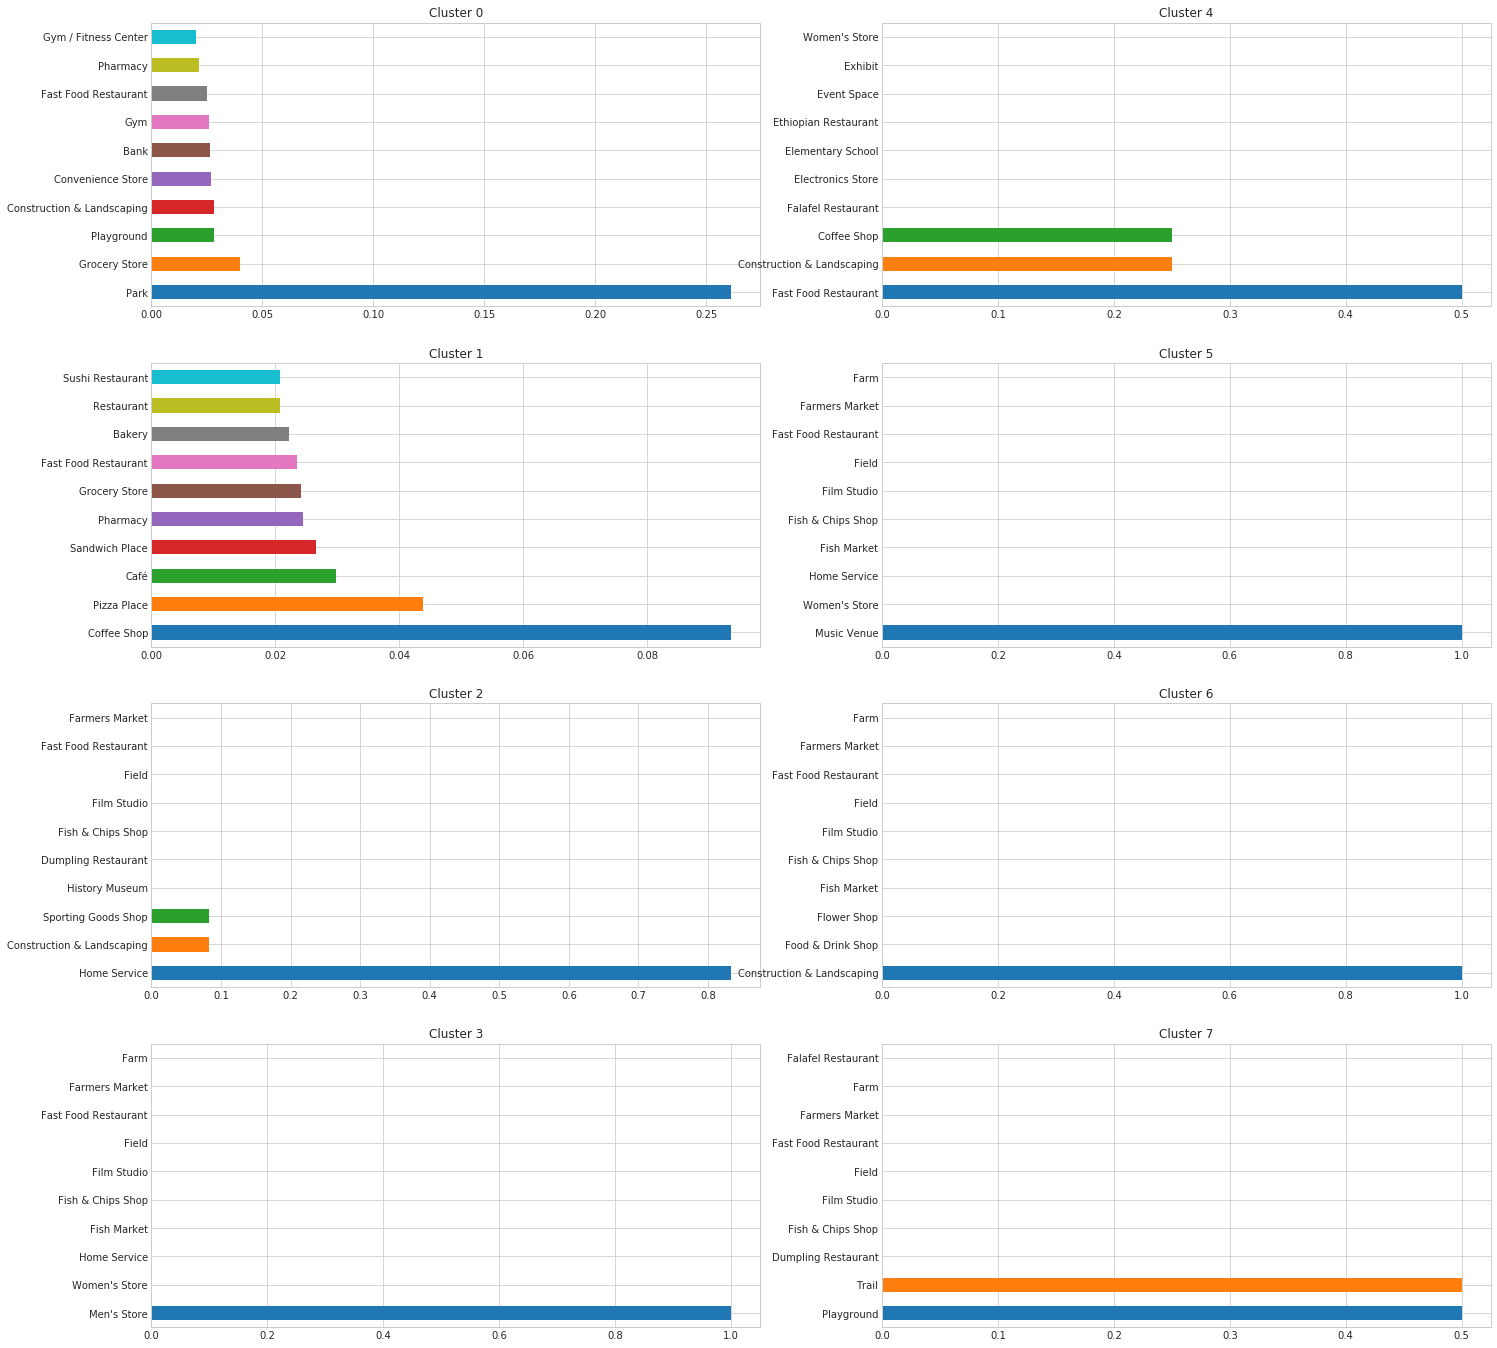

In [158]:
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(24,24))

for k in range(8):
    k_cluster = toronto_grouped_cluster.loc[k,:].sort_values(ascending=False)[:10]
    k_cluster.plot(kind='barh',ax=axes[k%4][k//4])
    axes[k%4][k//4].set_title('Cluster {}'.format(k))

# PART 3: END  